# Community detection for bicycle-sharing demand
For bicycle sharing demand, each trip of can be seen as a process from the starting loaction to the end loaction. When we regard the start point and the end point as nodes, and the travel between them as edges, a network can be constructed. By analysing this network, we can get information about the spatial connection structure of the city or the macro travel characteristics of the bicycle sharing demand.
Community detection, also called graph partition, helps us to reveal the hidden relations among the nodes in the network. In this example, we will introduce how to integrate TransBigData into the analysis process of community detection from bicycle-sharing data.

## Data preprocessing

In [1]:
# Fristly, import packages.
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd

In [2]:
#Read bicycle sharing data
bikedata = pd.read_csv(r'data/bikedata-sample.csv')
bikedata.head(5)

BIKE_ID           DATA_TIME  LOCK_STATUS   LONGITUDE   LATITUDE
0        5  2018-09-01 0:00:36            1  121.363566  31.259615
1        6  2018-09-01 0:00:50            0  121.406226  31.214436
2        6  2018-09-01 0:03:01            1  121.409402  31.215259
3        6  2018-09-01 0:24:53            0  121.409228  31.214427
4        6  2018-09-01 0:26:38            1  121.409771  31.214406

In [3]:
#Read the polygon of the study area
shanghai_admin = gpd.read_file(r'data/shanghai.json')
#delete the data outside of the study area
bikedata = tbd.clean_outofshape(bikedata, shanghai_admin, col=['LONGITUDE', 'LATITUDE'], accuracy=500)

Identify Bicycle sharing trip information using ``tbd.bikedata_to_od``

In [4]:
move_data,stop_data = tbd.bikedata_to_od(bikedata,
                   col = ['BIKE_ID','DATA_TIME','LONGITUDE','LATITUDE','LOCK_STATUS'])
move_data.head(5)

BIKE_ID                stime        slon       slat  \
96          6   2018-09-01 0:00:50  121.406226  31.214436   
561         6   2018-09-01 0:24:53  121.409228  31.214427   
564         6   2018-09-01 0:50:16  121.409727  31.214403   
784         6   2018-09-01 0:53:38  121.413333  31.214951   
1028        6  2018-09-01 11:35:01  121.419261  31.213414   

                    etime        elon       elat  
96     2018-09-01 0:03:01  121.409402  31.215259  
561    2018-09-01 0:26:38  121.409771  31.214406  
564    2018-09-01 0:52:14  121.412610  31.214905  
784    2018-09-01 0:55:38  121.412656  31.217051  
1028  2018-09-01 11:35:13  121.419518  31.213657

In [5]:
#Calculate the travel distance
move_data['distance'] = tbd.getdistance(move_data['slon'],move_data['slat'],move_data['elon'],move_data['elat'])
#Remove too long and too short trips
move_data = move_data[(move_data['distance']>100)&(move_data['distance']<10000)]

Perform data gridding:

In [6]:
#obtain gridding params
bounds = (120.85, 30.67, 122.24, 31.87)
params = tbd.grid_params(bounds,accuracy = 500)
#aggregate the travel informations
od_gdf = tbd.odagg_grid(move_data, params, col=['slon', 'slat', 'elon', 'elat'])
od_gdf.head(5)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:91: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


SLONCOL  SLATCOL  ELONCOL  ELATCOL  count      SHBLON     SHBLAT  \
0           26       95       26       96      1  120.986782  31.097177   
40803      117      129      116      127      1  121.465519  31.250062   
40807      117      129      117      128      1  121.465519  31.250062   
40810      117      129      117      131      1  121.465519  31.250062   
40811      117      129      118      126      1  121.465519  31.250062   

           EHBLON     EHBLAT  \
0      120.986782  31.101674   
40803  121.460258  31.241069   
40807  121.465519  31.245565   
40810  121.465519  31.259055   
40811  121.470780  31.236572   

                                                geometry  
0      LINESTRING (120.98678 31.09718, 120.98678 31.1...  
40803  LINESTRING (121.46552 31.25006, 121.46026 31.2...  
40807  LINESTRING (121.46552 31.25006, 121.46552 31.2...  
40810  LINESTRING (121.46552 31.25006, 121.46552 31.2...  
40811  LINESTRING (121.46552 31.25006, 121.47078 31.2...

Visualize the OD data

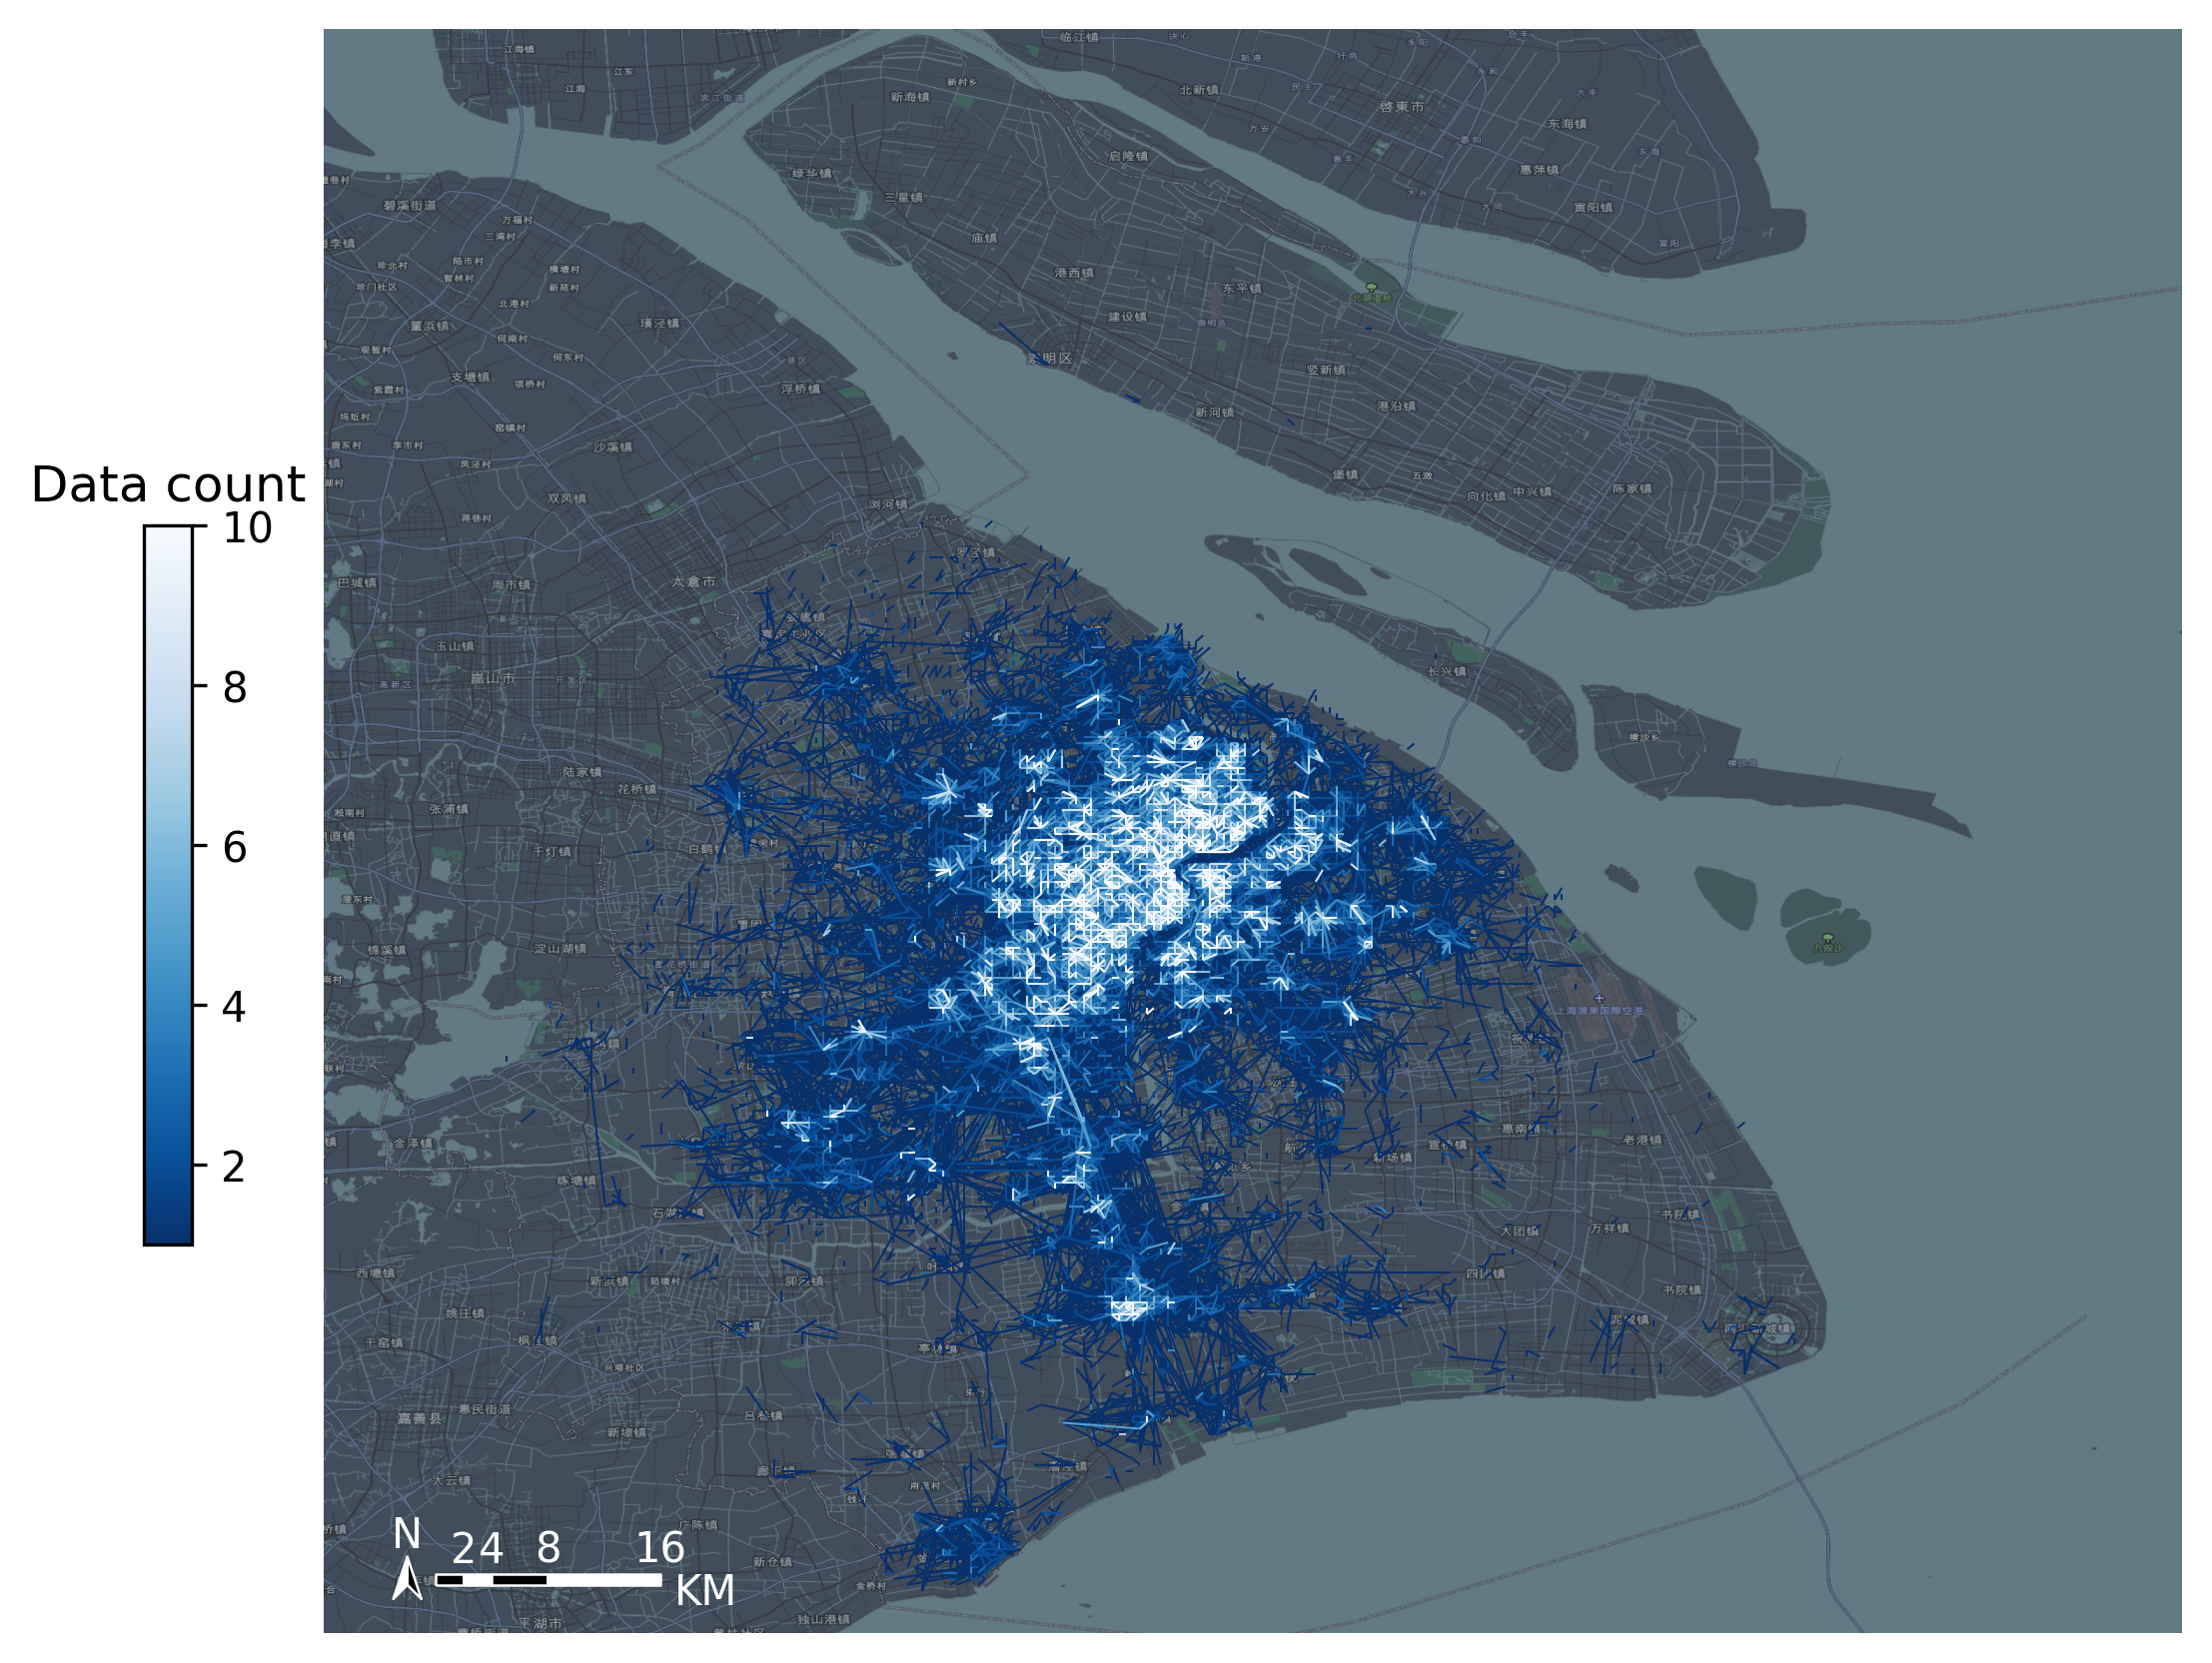

In [7]:
#Create figure
import matplotlib.pyplot as plt
import plot_map
fig =plt.figure(1,(8,8),dpi=300)
ax =plt.subplot(111)
plt.sca(ax)

#Load basemap
tbd.plot_map(plt,bounds,zoom = 11,style = 8)

#Create colorbar
cax = plt.axes([0.05, 0.33, 0.02, 0.3])
plt.title('Data count')
plt.sca(ax)

#Plot OD
od_gdf.plot(ax = ax,column = 'count',cmap = 'Blues_r',linewidth = 0.5,vmax = 10,cax = cax,legend = True)

#Plot compass and scale
tbd.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,textcolor = 'white',accuracy = 2000,rect = [0.06,0.03],zorder = 10)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()

## Create Network 

### Extract node data

Combine the ``LONCOL`` and ``LATCOL`` columns into one field and extract node set

In [8]:
#Combine the ``LONCOL`` and ``LATCOL`` columns into one field
od_gdf['S'] = od_gdf['SLONCOL'].astype(str) + ',' + od_gdf['SLATCOL'].astype(str)
od_gdf['E'] = od_gdf['ELONCOL'].astype(str) + ',' + od_gdf['ELATCOL'].astype(str)
#extract node set
node = set(od_gdf['S'])|set(od_gdf['E'])
node = pd.DataFrame(node)
#reindex the node
node['id'] = range(len(node))
node

0    id
0       88,46     0
1     128,113     1
2       81,63     2
3      111,71     3
4     115,108     4
...       ...   ...
9806    87,49  9806
9807  156,138  9807
9808   183,44  9808
9809   130,88  9809
9810    84,74  9810

[9811 rows x 2 columns]

### Extract edge data

In [9]:
#Merge the node information to the OD data to extract edge data.
node.columns = ['S','S_id']
od_gdf = pd.merge(od_gdf,node,on = ['S'])
node.columns = ['E','E_id']
od_gdf = pd.merge(od_gdf,node,on = ['E'])
#Extract edge data
edge = od_gdf[['S_id','E_id','count']]
edge

S_id  E_id  count
0      4139  5715      1
1      1402  4755      1
2      8126  4755      3
3      3475  4755      1
4      6942  4755      1
...     ...   ...    ...
68468  6055  9478      2
68469  9607   724      2
68470  4031   179      2
68471  1464  2238      3
68472  4459  6057      3

[68473 rows x 3 columns]

### Create Network

In [10]:
import igraph
#Create Network
g = igraph.Graph()
#Add node
g.add_vertices(len(node))
#Add edge
g.add_edges(edge[['S_id','E_id']].values)
#Add weight
edge_weights = edge[['count']].values
for i in range(len(edge_weights)):
    g.es[i]['weight'] = edge_weights[i]

### Community detection

In [11]:
#Community detection
g_clustered = g.community_multilevel(weights = edge_weights, return_levels=False)

In [12]:
#Modularity
g_clustered.modularity

0.8492154962455006

In [13]:
#Assign the group result to the node
node['group'] = g_clustered.membership
#rename the columns
node.columns = ['grid','node_id','group']
node

grid  node_id  group
0       88,46        0      0
1     128,113        1      1
2       81,63        2      2
3      111,71        3      3
4     115,108        4      4
...       ...      ...    ...
9806    87,49     9806      0
9807  156,138     9807     16
9808   183,44     9808    539
9809   130,88     9809     11
9810    84,74     9810     26

[9811 rows x 3 columns]

## Visualize the community

In [14]:
#Count the number of grids per community
group = node['group'].value_counts()
#Extract communities with more than 10 grids
group = group[group>10]
#Retain only these community grids
node = node[node['group'].apply(lambda r:r in group.index)]

#Get the grid number
node['LONCOL'] = node['grid'].apply(lambda r:r.split(',')[0]).astype(int)
node['LATCOL'] = node['grid'].apply(lambda r:r.split(',')[1]).astype(int)
#Generate the geometry
node['geometry'] = tbd.gridid_to_polygon(node['LONCOL'],node['LATCOL'],params)
#Change it into GeoDataFrame
import geopandas as gpd
node = gpd.GeoDataFrame(node)
node

/var/folders/b0/q8rx9fj965b5p7yqq8zhvdx80000gn/T/ipykernel_12274/418053260.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node['LONCOL'] = node['grid'].apply(lambda r:r.split(',')[0]).astype(int)
/var/folders/b0/q8rx9fj965b5p7yqq8zhvdx80000gn/T/ipykernel_12274/418053260.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node['LATCOL'] = node['grid'].apply(lambda r:r.split(',')[1]).astype(int)
/var/folders/b0/q8rx9fj965b5p7yqq8zhvdx80000gn/T/ipykernel_12274/418053260.py:12: SettingWithCopyWarning: 
A 

grid  node_id  group  LONCOL  LATCOL  \
0       88,46        0      0      88      46   
1     128,113        1      1     128     113   
3      111,71        3      3     111      71   
4     115,108        4      4     115     108   
5       72,93        5      5      72      93   
...       ...      ...    ...     ...     ...   
9805   77,156     9805     10      77     156   
9806    87,49     9806      0      87      49   
9807  156,138     9807     16     156     138   
9809   130,88     9809     11     130      88   
9810    84,74     9810     26      84      74   

                                               geometry  
0     POLYGON ((121.31032 30.87460, 121.31558 30.874...  
1     POLYGON ((121.52076 31.17587, 121.52602 31.175...  
3     POLYGON ((121.43132 30.98701, 121.43658 30.987...  
4     POLYGON ((121.45237 31.15339, 121.45763 31.153...  
5     POLYGON ((121.22615 31.08594, 121.23141 31.085...  
...                                                 ...  
9805  POLYGON ((121.25245 31.36922, 121.25772 31.369...  
9806  POLYGON ((121.30506 30.88809, 121.31032 30.888...  
9807  POLYGON ((121.66806 31.28828, 121.67332 31.288...  
9809  POLYGON ((121.53128 31.06345, 121.53654 31.063...  
9810  POLYGON ((121.28928 31.00050, 121.29454 31.000...  

[8527 rows x 6 columns]

<AxesSubplot:>

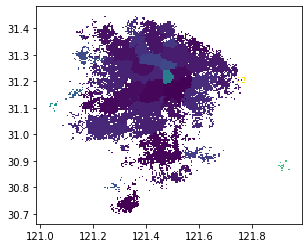

In [15]:
node.plot('group')

In [16]:
#Use the group column to merge polygon
node_community = tbd.merge_polygon(node,'group')
#Input polygon GeoDataFrame data, take the exterior boundary of the polygon to form a new polygon
node_community = tbd.polyon_exterior(node_community,minarea = 0.000100)

/opt/anaconda3/lib/python3.8/site-packages/transbigdata/gisprocess.py:205: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for i in p:


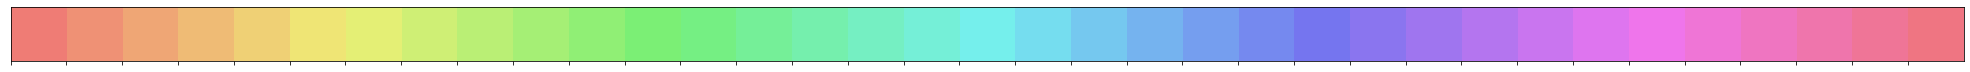

In [17]:
#Generate palette
import seaborn as sns
## l: Luminance
## s: Saturation
cmap = sns.hls_palette(n_colors=len(node_community), l=.7, s=0.8)
sns.palplot(cmap)

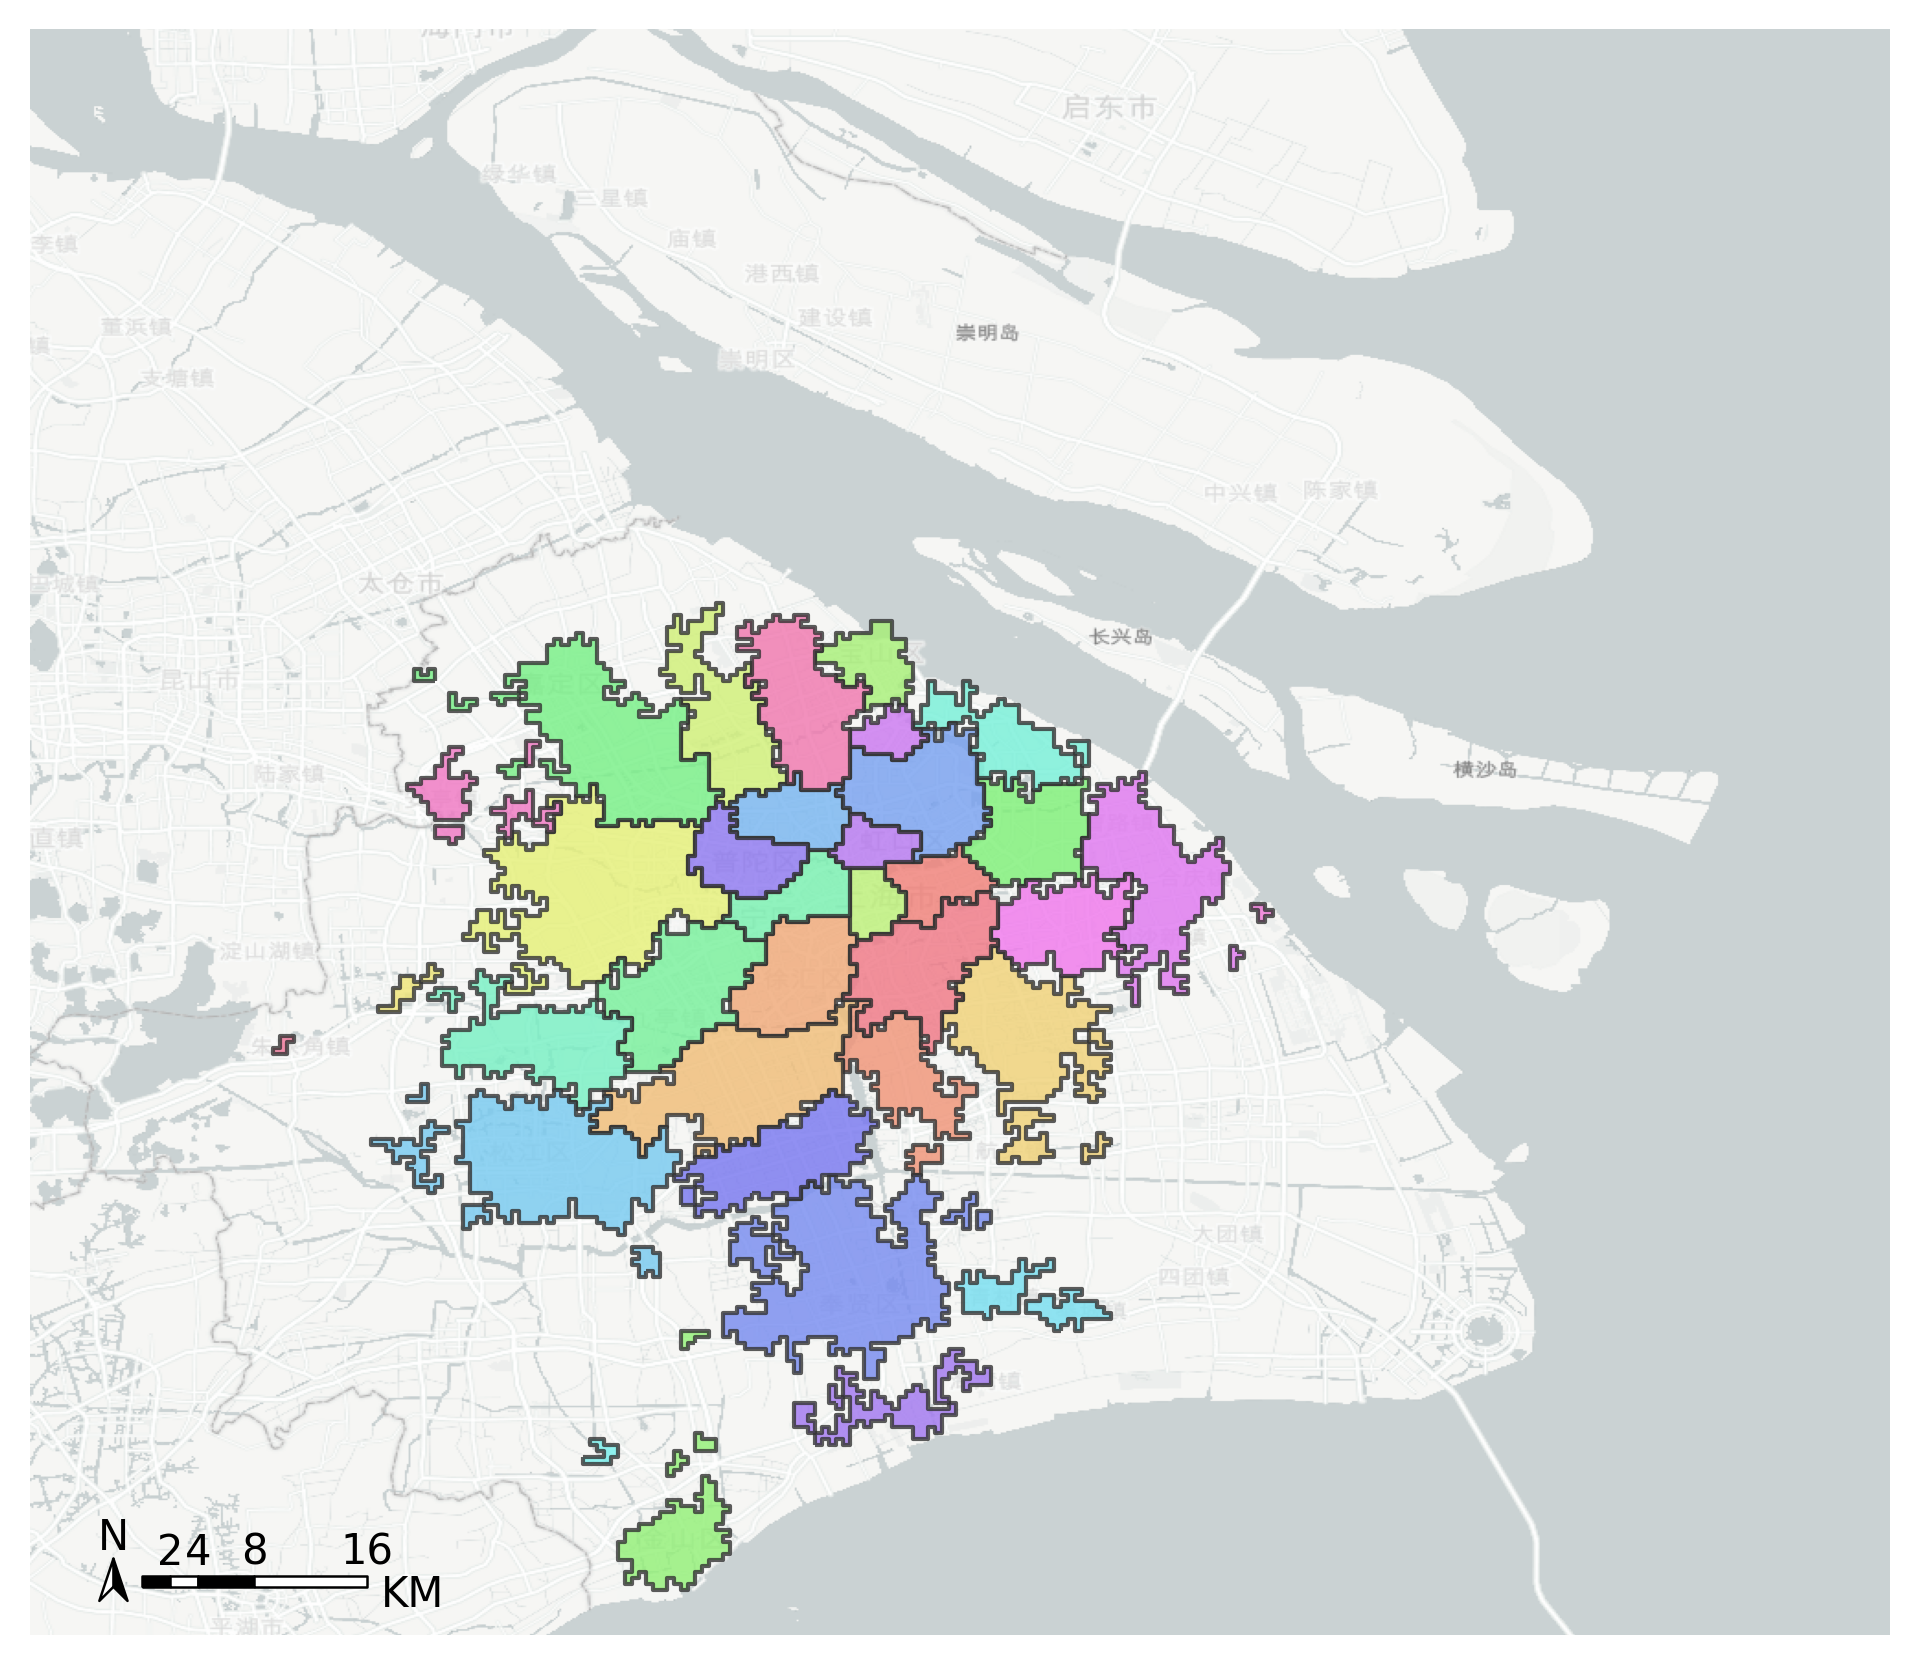

In [18]:
#Create figure
import matplotlib.pyplot as plt
import plot_map
fig =plt.figure(1,(8,8),dpi=300)
ax =plt.subplot(111)
plt.sca(ax)
#Load basemap
tbd.plot_map(plt,bounds,zoom = 10,style = 6)
#Set colormap
from matplotlib.colors import ListedColormap 
#Disrupting the order of the community
node_community = node_community.sample(frac=1)
#Plot community
node_community.plot(cmap = ListedColormap(cmap),ax = ax,edgecolor = '#333',alpha = 0.8)
#Add scale
tbd.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,textcolor = 'k'
              ,accuracy = 2000,rect = [0.06,0.03],zorder = 10)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()